In [2]:
import tensorflow as tf # This tells Colab that we are using TensorFlow

from tensorflow import keras # This is the main TensorFlow library
from tensorflow.keras import layers # We are building a Neural Network with several hidden layers
from tensorflow.keras.layers.experimental import preprocessing

print("Current TensorFlow version is", tf.__version__)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns # for visualization
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")
np.random.seed(42)

#Reading in the data as insurance dataframe
amazon = pd.read_csv("https://raw.githubusercontent.com/shstreuber/Data-Mining/master/data/amazon_toy_sample_clean.csv", encoding="ISO-8859-1")

#Verifying that we can see the data
amazon.head()

Current TensorFlow version is 2.8.2


,uniq_id,product_name,manufacturer,price,number_available_in_stock,status,number_of_reviews,number_of_answered_questions,average_review_rating_of_5,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews
0,dafc6b4ba4b4a3e7b4ff83402a196ae8,Dinosaur Eggs,Halsall,0.29,3,new,3,2,4.0,Figures & Playsets > Dinosaurs,http://www.amazon.co.uk/Hatch-em-TY63-Hatching...,Manufacturer's Description not available,Technical Details Item Weight82 g Product Dime...,Not available,http://www.amazon.co.uk/Hatch-em-TY63-Hatching...,None,Fascinating fun // 4.0 // 25 Nov. 2008 // By\n...
1,ba85fb9368114fce646379ed12750a5f,Neopets 4 Trading Card Fun Packs (2 Bonus Cards),Neopets,0.38,2,new,2,1,4.5,Hobbies > Trading Cards & Accessories > Packs ...,Unknown,Manufacturer's Description not available,Technical Details Item Weight454 g Product Dim...,Not available,Not available,None,Never Too Old // 4.0 // 6 Nov. 2013 // By\n ...
2,14e24c29ba38c2717754baa2638f242a,"Latex Assorted Water Balloons, Pack of 40",Unique Party,0.39,7,new,2,1,4.5,Party Supplies > Decorations > Balloons,http://www.amazon.co.uk/Latex-Cannonball | htt...,Colour Name:Assorted Bold | Size Name:Pack o...,Technical Details Item Weight222 g Product Dim...,Colour Name:Assorted Bold | Size Name:Pack o...,http://www.amazon.co.uk/Water-Bombs-Pack-100-A...,None,Great item // 4.0 // 27 Dec. 2015 // By\n \...
3,048d64d2ba61c23f6280663a7281ff19,iCarly Shopper Bag - Lilac and Pink,Trade Mark Collections,0.50,4,new,7,2,4.6,Sports Toys & Outdoor > Beach Toys > Airbeds &...,http://www.amazon.co.uk/iCarly-Large-Rectangle...,Manufacturer's Description The iCarly Shopping...,NaN,Manufacturer's Description The iCarly Shopping...,http://www.amazon.co.uk/Namco-Bandai-Icarly/dp...,None,Very good product // 5.0 // 26 Mar. 2014 // By...
4,7b72f597db5d74d35c4f91ef69708cf1,4 Packs of Mini Colouring Pencils (4 pencils i...,unisex party bag fillers,0.60,7,new,21,1,4.3,Arts & Crafts > Colouring Pencils,http://www.amazon.co.uk/12-Mini-Christmas-Colo...,4 x Mini Colouring Pencils - Pack of 4 Size: 8...,Technical Details Item Weight59 g Product Dime...,4 x Mini Colouring Pencils - Pack of 4 Size: 8...,http://www.amazon.co.uk/20-Packs-Wax-Crayons-P...,How many packs in the box. // I got four Mimi ...,Well made and presented // 4.0 // 6 April 2015...


In [4]:
amazon2 = amazon[['price','number_available_in_stock','number_of_reviews','number_of_answered_questions','average_review_rating_of_5']]
amazon2.head()

,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating_of_5
0,0.29,3,3,2,4.0
1,0.38,2,2,1,4.5
2,0.39,7,2,1,4.5
3,0.50,4,7,2,4.6
4,0.60,7,21,1,4.3


In [6]:
train_dataset = amazon2.sample(frac=0.8, random_state=0)
test_dataset = amazon2.drop(train_dataset.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [7]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('average_review_rating_of_5')
test_labels = test_features.pop('average_review_rating_of_5')

In [8]:
normalizer = preprocessing.Normalization(axis=-1)

In [9]:
normalizer.adapt(np.array(train_features))

In [10]:
print(normalizer.mean.numpy())

[[20.150934  8.713164 11.578219  4.002565]]


In [11]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('Original data:', first)
  print()
  print('Normalized data:', normalizer(first).numpy())

Original data: [[14.  2.  1.  1.]]

Normalized data: [[-0.13 -0.74 -0.26 -0.21]]


In [14]:
# First, we build the normalization layer:
price_new = np.array(train_features['price'])

price_normalizer = preprocessing.Normalization(input_shape=[1,], axis=None)
price_normalizer.adapt(price_new)

In [15]:
# Now we build the framework that holds all the models:
price_model = tf.keras.Sequential([
    price_normalizer,
    layers.Dense(units=1)
])

price_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [17]:
price_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [18]:
%%time
history = price_model.fit(
    train_features['price'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data. Validation means that we test as we go, on a 20% subset of the training data
    validation_split = 0.2)

CPU times: user 21.9 s, sys: 1.27 s, total: 23.2 s
Wall time: 42 s


In [19]:
train_features['price']

3790     14.00
733       2.89
3931     14.95
3385     12.02
3169     11.28
         ...  
5141     25.28
6213    114.98
6316    299.73
5530     34.46
239       1.60
Name: price, Length: 5069, dtype: float64

In [21]:
x = tf.linspace(0.0, 250, 251)
y = price_model.predict(x)

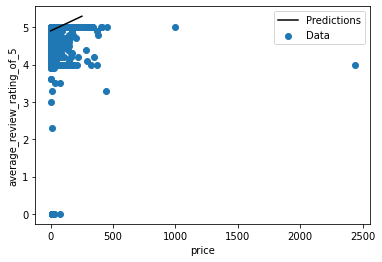

In [22]:
def plot_age(x, y):
  plt.scatter(train_features['price'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('price')
  plt.ylabel('average_review_rating_of_5')
  plt.legend()
plot_age(x,y) 

In [23]:
test_results = {}

test_results['price_model'] = price_model.evaluate(
    test_features['price'],
    test_labels, verbose=0)

In [24]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [25]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(4, 1) dtype=float32, numpy=
array([[ 0.41208887],
       [ 0.35893047],
       [-0.7323006 ],
       [ 0.0379473 ]], dtype=float32)>

In [26]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [27]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=10,
    # 10 epochs, so we turn on logging
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/10
127/127 [==============================] - 1s 4ms/step - loss: 1.1419 - val_loss: 0.2775
Epoch 2/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3230 - val_loss: 0.2825
Epoch 3/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3196 - val_loss: 0.2825
Epoch 4/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3174 - val_loss: 0.3232
Epoch 5/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3283 - val_loss: 0.2752
Epoch 6/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3162 - val_loss: 0.3031
Epoch 7/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3255 - val_loss: 0.3063
Epoch 8/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3145 - val_loss: 0.2767
Epoch 9/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3236 - val_loss: 0.3141
Epoch 10/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3234 - val_loss: 0.3135

In [28]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

In [29]:
def build_and_compile_model(norm):
  model = keras.Sequential([                 # Here you are setting up the keras.Sequential architecture
      norm,                                  # This is the normalizer function we built before
      layers.Dense(64, activation='relu'),   # Here is the first hidden layer--64 nodes, built with the relu function
      layers.Dense(64, activation='relu'),   # Here is the second hidden layer, also built with the relu function
      layers.Dense(1)                        # Here is the Dense layer for a single output because we are working on a REGRESSION
  ])                                         # AND WE'RE DONE WITH BUILDING THE MODEL!

  model.compile(loss='mean_absolute_error',   # Now we configure the runtime for our model; the loss function is mean absolute error--makes sense for a regression!
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [30]:
dnn_price_model = build_and_compile_model(price_normalizer)

In [31]:
dnn_price_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


In [33]:
%%time
history = dnn_price_model.fit(
    train_features['price'], train_labels,
    validation_split=0.2,
    verbose=1, epochs=10)

Epoch 1/10
127/127 [==============================] - 1s 5ms/step - loss: 2.3899 - val_loss: 0.5070
Epoch 2/10
127/127 [==============================] - 0s 4ms/step - loss: 0.4450 - val_loss: 0.3234
Epoch 3/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3265 - val_loss: 0.2951
Epoch 4/10
127/127 [==============================] - 0s 4ms/step - loss: 0.3186 - val_loss: 0.2972
Epoch 5/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3158 - val_loss: 0.2989
Epoch 6/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3195 - val_loss: 0.2944
Epoch 7/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3142 - val_loss: 0.2951
Epoch 8/10
127/127 [==============================] - 0s 2ms/step - loss: 0.3197 - val_loss: 0.2949
Epoch 9/10
127/127 [==============================] - 0s 2ms/step - loss: 0.3192 - val_loss: 0.2933
Epoch 10/10
127/127 [==============================] - 0s 2ms/step - loss: 0.3169 - val_loss: 0.3085

In [34]:
train_labels

3790    5.0
733     4.8
3931    5.0
3385    5.0
3169    4.2
       ... 
5141    4.8
6213    5.0
6316    5.0
5530    5.0
239     4.5
Name: average_review_rating_of_5, Length: 5069, dtype: float64

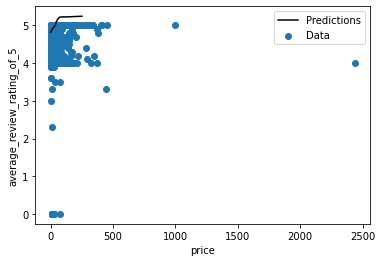

In [35]:
x = tf.linspace(0.0, 250, 251)
y = dnn_price_model.predict(x)

plot_age(x, y)

In [37]:
test_results['dnn_price_model'] = dnn_price_model.evaluate(
    test_features['price'], test_labels,
    verbose=0)

In [38]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 4)                9         
 n)                                                              
                                                                 
 dense_5 (Dense)             (None, 64)                320       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [39]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=10)

Epoch 1/10
127/127 [==============================] - 1s 3ms/step - loss: 2.1825 - val_loss: 0.6985
Epoch 2/10
127/127 [==============================] - 0s 3ms/step - loss: 0.5465 - val_loss: 0.3323
Epoch 3/10
127/127 [==============================] - 0s 3ms/step - loss: 0.3281 - val_loss: 0.2730
Epoch 4/10
127/127 [==============================] - 1s 4ms/step - loss: 0.2927 - val_loss: 0.2502
Epoch 5/10
127/127 [==============================] - 1s 4ms/step - loss: 0.2792 - val_loss: 0.2608
Epoch 6/10
127/127 [==============================] - 0s 3ms/step - loss: 0.2773 - val_loss: 0.2454
Epoch 7/10
127/127 [==============================] - 0s 3ms/step - loss: 0.2752 - val_loss: 0.2387
Epoch 8/10
127/127 [==============================] - 0s 3ms/step - loss: 0.2673 - val_loss: 0.2473
Epoch 9/10
127/127 [==============================] - 0s 2ms/step - loss: 0.2721 - val_loss: 0.2473
Epoch 10/10
127/127 [==============================] - 0s 2ms/step - loss: 0.2651 - val_loss: 0.2417

In [40]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=1, epochs=0)

CPU times: user 79.2 ms, sys: 808 µs, total: 80 ms
Wall time: 94.6 ms


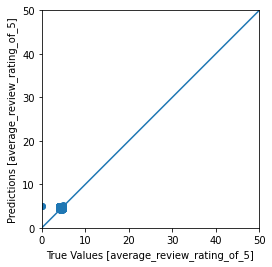

In [41]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [average_review_rating_of_5]')
plt.ylabel('Predictions [average_review_rating_of_5]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [42]:
test_predictions = dnn_model.predict(test_features).flatten()

In [43]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [45]:
pd.DataFrame(test_results, index=['Mean absolute error [average_review_rating_of_5]']).T

,Mean absolute error [average_review_rating_of_5]
price_model,0.312581
linear_model,0.325286
dnn_price_model,0.323290
dnn_model,0.263415
